In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

# Extract Features from Wave Files

In [3]:
#directory to training data and json file
train_dir='/home/aka/Documents/nsynth-train/audio/'
#directory to training data and json file
valid_dir='/home/aka/Documents/nsynth-valid/audio/'
#directory to training data and json file
test_dir='/home/aka/Documents/nsynth-test/audio/'

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [5]:
#read the raw json files as given in the training set
df_train_raw = pd.read_json(path_or_buf='nsynth-train/examples.json', orient='index')

In [6]:
#Get a count of instruments in ascending order
n_class_train= df_train_raw['instrument_family'].value_counts(ascending=True)
n_class_train

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [7]:
#Sample n files
df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(5000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

In [8]:
df_train_sample.head() #EDA exploratory data analysis 

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_083-036-127,208076,16000,36,2,bass,bass_synthetic_083,bass_synthetic_083-036-127,"[bright, distortion]",synthetic,127,0,723,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_035-031-025,284231,16000,31,2,bass,bass_synthetic_035,bass_synthetic_035-031-025,"[long_release, multiphonic]",synthetic,25,0,425,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 0]"
bass_synthetic_075-090-050,147776,16000,90,2,bass,bass_synthetic_075,bass_synthetic_075-090-050,"[fast_decay, percussive]",synthetic,50,0,678,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]"
bass_synthetic_028-024-050,252819,16000,24,2,bass,bass_synthetic_028,bass_synthetic_028-024-050,[dark],synthetic,50,0,364,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
bass_electronic_019-039-075,255680,16000,39,1,bass,bass_electronic_019,bass_electronic_019-039-075,[],electronic,75,0,771,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


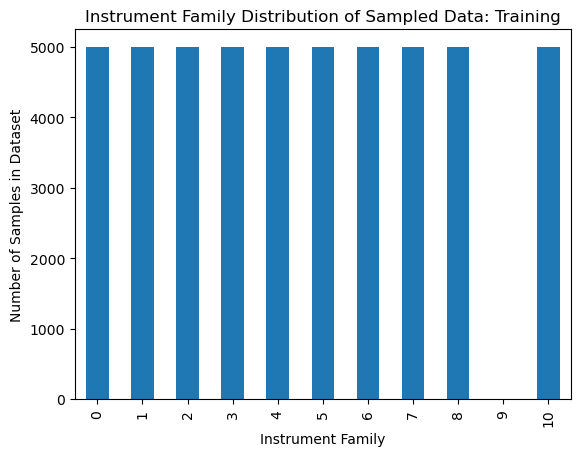

In [11]:
#Display instrument distrution
df_train_sample['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [12]:
#save the train file index as list
filenames_train = df_train_sample.index.tolist()

In [14]:
#save the list to a pickle file
with open('DataWrangling/filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [15]:
#extract the filenames from the validation dataset
df_valid = pd.read_json(path_or_buf='nsynth-valid/examples.json', orient='index')

#save the train file index as list
filenames_valid = df_valid.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

In [16]:
#extract the filenames from the testing dataset
df_test = pd.read_json(path_or_buf='nsynth-test/examples.json', orient='index')

#save the train file index as list
filenames_test = df_test.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

In [17]:
def feature_extract(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc = np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [18]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

In [19]:
#create dictionary to store all test features
dict_test = {}
#loop over every file in the list
for file in filenames_test:
    #extract the features
    features = feature_extract(test_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test[file] = features

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [20]:
#convert dict to dataframe
features_test = pd.DataFrame.from_dict(dict_test, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_068-049-025,1,"[-522.8658, 46.664146, 34.3798, 24.787592, 17....","[0.010030989, 0.02624286, 0.043270763, 0.09308...","[0.14551312, 0.82559353, 0.07650902, 0.0340558...","[35.980332057104036, 29.09879218811833, 27.842..."
keyboard_electronic_001-021-127,0,"[-444.64713, 193.89459, 27.29581, -3.6878698, ...","[0.055242054, 0.19966866, 11.731714, 20.330849...","[0.08902063, 0.10597091, 0.077824585, 0.392217...","[19.948747046905105, 19.841753347165195, 18.75..."
guitar_acoustic_010-066-100,0,"[-439.37473, 59.548584, 2.893683, -12.038998, ...","[0.0014635224, 0.0026336862, 0.0022025586, 0.0...","[0.10209415, 0.11988667, 0.064387664, 0.072573...","[12.37305152614007, 34.62256118413128, 35.3186..."
reed_acoustic_037-068-127,1,"[-374.56097, 70.88924, -41.18462, -20.965775, ...","[0.0001457598, 0.00046337667, 0.00040781155, 2...","[0.05025812, 0.038772635, 0.023343502, 0.36616...","[19.620149137888788, 25.605482802495253, 30.76..."
flute_acoustic_002-077-100,1,"[-365.42816, 13.425872, -43.5183, 20.321768, -...","[4.926747e-05, 0.0001282078, 0.00046132316, 0....","[0.07728491, 0.08046897, 0.073985286, 0.037789...","[20.51487418872989, 10.440352061701418, 40.267..."


In [21]:
#extract mfccs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(),index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

#extract spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(),index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')


#extract chroma
chroma_test = pd.DataFrame(features_test.chroma.values.tolist(),index=features_test.index)
chroma_test = chroma_test.add_prefix('chroma_')


#extract contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(),index=features_test.index)
contrast_test = chroma_test.add_prefix('contrast_')

#drop the old columns
features_test = features_test.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test=pd.concat([features_test, mfcc_test, spectro_test, chroma_test, contrast_test],
                           axis=1, join='inner')
df_features_test.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_068-049-025,1,-522.865784,46.664146,34.379799,24.787592,17.420424,10.198802,4.609534,1.380598,-1.023342,...,0.076509,0.034056,0.035498,0.025267,0.019353,0.038954,0.092328,0.087519,0.061090,0.091117
keyboard_electronic_001-021-127,0,-444.647125,193.894592,27.295811,-3.687870,6.295289,8.091359,10.286986,6.085114,2.499446,...,0.077825,0.392218,0.563529,0.143236,0.164834,0.211634,0.353580,0.422365,0.019230,0.009007
guitar_acoustic_010-066-100,0,-439.374725,59.548584,2.893683,-12.038998,-12.553400,-11.452487,-12.534291,-20.458334,-19.255125,...,0.064388,0.072573,0.091863,0.090990,0.840737,0.093613,0.048391,0.030883,0.015003,0.009667
reed_acoustic_037-068-127,1,-374.560974,70.889236,-41.184620,-20.965775,-50.554077,-16.927151,-28.767250,-18.298323,-15.653653,...,0.023344,0.366166,0.036109,0.006731,0.023056,0.020713,0.885966,0.061736,0.016221,0.002263
flute_acoustic_002-077-100,1,-365.428162,13.425872,-43.518299,20.321768,-29.725790,-21.518467,-17.812229,-10.225934,8.543968,...,0.073985,0.037789,0.052419,0.910790,0.022027,0.030132,0.009579,0.028886,0.048302,0.016970


In [22]:
targets_test = []
for name in df_features_test.index.tolist():
    targets_test.append(instrument_code(name))

df_features_test['targets'] = targets_test

In [23]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)

In [24]:
df_features_test.shape

(4096, 167)

## Traning Set

In [25]:
start_train = time.time()

#create dictionary to store all test features
dict_train = {}
#loop over every file in the list
for file in filenames_train:
    #extract the features
    features = feature_extract(train_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_train[file] = features

end_train=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train), end_train - start_train))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 50000 files is 19214.93999361992 seconds


In [ ]:
#convert dict to dataframe
features_train = pd.DataFrame.from_dict(dict_train, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train.head()

In [27]:
#extract mfccs
mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(),
                          index=features_train.index)
mfcc_train = mfcc_train.add_prefix('mfcc_')

#extract spectro
spectro_train = pd.DataFrame(features_train.spectro.values.tolist(),
                             index=features_train.index)
spectro_train = spectro_train.add_prefix('spectro_')


#extract chroma
chroma_train = pd.DataFrame(features_train.chroma.values.tolist(),
                            index=features_train.index)
chroma_train = chroma_train.add_prefix('chroma_')


#extract contrast
contrast_train = pd.DataFrame(features_train.contrast.values.tolist(),
                              index=features_train.index)
contrast_train = chroma_train.add_prefix('contrast_')

#drop the old columns
features_train = features_train.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train=pd.concat([features_train, mfcc_train, spectro_train, chroma_train, contrast_train],
                           axis=1, join='inner')
df_features_train.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_083-036-127,1,-215.735214,203.520248,-24.573511,-13.739591,12.981566,13.971969,4.032739,1.523654,5.437962,...,0.094544,0.027852,0.148277,0.013933,0.020755,0.350970,0.008265,0.007015,0.076367,0.200041
bass_synthetic_035-031-025,0,-401.960266,66.963104,52.627304,40.268837,28.114470,19.916792,14.606725,11.273973,8.552884,...,0.011615,0.000000,0.023124,0.045701,0.123211,0.964425,0.078941,0.006567,0.002147,0.000000
bass_synthetic_075-090-050,1,-681.080322,5.502732,0.478403,0.824968,2.747365,3.543370,1.626568,-0.638081,-0.192059,...,0.130222,0.131774,0.155086,0.148135,0.191533,0.207755,0.213146,0.163551,0.077254,0.156310
bass_synthetic_028-024-050,0,-432.107208,143.968430,91.772957,40.883369,13.048125,7.531934,9.935453,9.098906,4.396384,...,0.101049,0.035636,0.086192,0.000000,0.000000,0.280554,0.000000,0.003094,0.006244,0.076018
bass_electronic_019-039-075,0,-458.583588,155.394806,89.419495,48.771755,24.855350,1.584153,-15.029453,-15.952425,-6.990792,...,0.119470,0.695661,0.102126,0.048201,0.030898,0.183257,0.033676,0.059994,0.481457,0.046375


In [28]:
targets_train = []
for name in df_features_train.index.tolist():
    targets_train.append(instrument_code(name))


In [29]:
df_features_train['targets'] = targets_train

In [30]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_train.pickle', 'wb') as f:
    pickle.dump(df_features_train, f)

In [31]:
df_features_train.shape

(50000, 167)

## Validation Set

In [32]:
start_valid = time.time()

#create dictionary to store all test features
dict_valid = {}
#loop over every file in the list
for file in filenames_valid:
    #extract the features
    features = feature_extract(valid_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_valid[file] = features

end_valid=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid), end_valid - start_valid))

/home/aka/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Time to extract 12678 files is 4564.2714874744415 seconds


In [33]:
#convert dict to dataframe
features_valid = pd.DataFrame.from_dict(dict_valid, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid.head()

,harmonic,mfcc,spectro,chroma,contrast
keyboard_acoustic_004-060-025,1,"[-475.23547, 57.881565, 45.41308, 33.631557, 2...","[1.1800027, 2.7473865, 0.97745705, 2.6299975, ...","[0.7166769, 0.118479714, 0.11610127, 0.0989934...","[20.83616053735028, 29.13231210190147, 28.2069..."
bass_synthetic_033-050-100,1,"[-423.16907, 69.13418, 45.36877, 22.640656, 8....","[2.3157597, 0.02870563, 0.035071626, 0.1275377...","[0.10281316, 0.12115274, 0.8339974, 0.21695851...","[30.731925079555808, 29.642553887634914, 32.86..."
bass_synthetic_009-052-050,0,"[-151.4592, 56.180984, -52.366467, 74.293594, ...","[0.819314, 0.022450991, 0.012858832, 0.0213032...","[0.0009446367, 0.0, 0.0019586482, 0.054268196,...","[32.36749747896233, 30.655247758435255, 34.711..."
keyboard_electronic_003-064-127,0,"[-500.15427, 47.05853, 13.788354, 8.744275, 3....","[0.00067951076, 0.0030120846, 0.016500076, 0.0...","[0.0, 0.0, 0.0009528077, 0.079969384, 0.775525...","[17.152303256722128, 29.867041144449978, 30.17..."
bass_synthetic_034-030-050,1,"[-411.7628, 67.75837, 38.892403, 56.140118, 24...","[0.96107304, 4.6424894, 84.44767, 434.86514, 8...","[0.046644557, 0.39849162, 0.026936369, 0.01650...","[28.739367387266007, 20.733264721175146, 20.37..."


In [34]:
#extract mfccs
mfcc_valid = pd.DataFrame(features_valid.mfcc.values.tolist(),
                          index=features_valid.index)
mfcc_valid = mfcc_valid.add_prefix('mfcc_')

#extract spectro
spectro_valid = pd.DataFrame(features_valid.spectro.values.tolist(),
                             index=features_valid.index)
spectro_valid = spectro_valid.add_prefix('spectro_')


#extract chroma
chroma_valid = pd.DataFrame(features_valid.chroma.values.tolist(),
                            index=features_valid.index)
chroma_valid = chroma_valid.add_prefix('chroma_')


#extract contrast
contrast_valid = pd.DataFrame(features_valid.contrast.values.tolist(),
                              index=features_valid.index)
contrast_valid = chroma_valid.add_prefix('contrast_')

#drop the old columns
features_valid = features_valid.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid=pd.concat([features_valid, mfcc_valid, spectro_valid, chroma_valid, contrast_valid],
                           axis=1, join='inner')
df_features_valid.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
keyboard_acoustic_004-060-025,1,-475.235474,57.881565,45.413078,33.631557,23.860250,16.503078,11.231784,6.607216,2.438399,...,0.116101,0.098993,0.212848,0.251691,0.214841,0.128957,0.139373,0.083054,0.056506,0.099800
bass_synthetic_033-050-100,1,-423.169067,69.134178,45.368771,22.640656,8.431941,1.126918,-2.505025,-3.276568,-2.163706,...,0.833997,0.216959,0.059687,0.037414,0.035974,0.023575,0.001356,0.263913,0.016409,0.035910
bass_synthetic_009-052-050,0,-151.459198,56.180984,-52.366467,74.293594,-48.825958,37.103230,-37.218937,17.417768,-20.727285,...,0.001959,0.054268,0.890012,0.049923,0.000945,0.000000,0.113582,0.000000,0.000000,0.434298
keyboard_electronic_003-064-127,0,-500.154266,47.058529,13.788354,8.744275,3.266100,-1.396002,-5.341508,-7.094386,-8.291027,...,0.000953,0.079969,0.775525,0.114564,0.052765,0.166308,0.116658,0.088980,0.002495,0.048147
bass_synthetic_034-030-050,1,-411.762787,67.758369,38.892403,56.140118,24.529562,26.548122,12.209658,12.024644,6.558580,...,0.026936,0.016504,0.055768,0.282189,0.750071,0.150681,0.031391,0.028311,0.036247,0.028427


In [35]:
targets_valid = []
for name in df_features_valid.index.tolist():
    targets_valid.append(instrument_code(name))

df_features_valid['targets'] = targets_valid

In [36]:
df_features_valid.shape

(12678, 167)

In [37]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid.pickle', 'wb') as f:
    pickle.dump(df_features_valid, f)

# Clean JSON Files

In [38]:
#extract qualities
train_qual = pd.DataFrame(df_train_sample.qualities.values.tolist(), index= df_train_sample.index)


#concatenate
json_train=pd.concat([df_train_sample, train_qual],
                           axis=1, join='inner')

json_train= json_train.drop(labels=['qualities'], axis=1)
json_train.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,...,0,1,2,3,4,5,6,7,8,9
bass_synthetic_083-036-127,208076,16000,36,2,bass,bass_synthetic_083,bass_synthetic_083-036-127,"[bright, distortion]",synthetic,127,...,1,0,1,0,0,0,0,0,0,0
bass_synthetic_035-031-025,284231,16000,31,2,bass,bass_synthetic_035,bass_synthetic_035-031-025,"[long_release, multiphonic]",synthetic,25,...,0,0,0,0,1,1,0,0,0,0
bass_synthetic_075-090-050,147776,16000,90,2,bass,bass_synthetic_075,bass_synthetic_075-090-050,"[fast_decay, percussive]",synthetic,50,...,0,0,0,1,0,0,0,1,0,0
bass_synthetic_028-024-050,252819,16000,24,2,bass,bass_synthetic_028,bass_synthetic_028-024-050,[dark],synthetic,50,...,0,1,0,0,0,0,0,0,0,0
bass_electronic_019-039-075,255680,16000,39,1,bass,bass_electronic_019,bass_electronic_019-039-075,[],electronic,75,...,0,0,0,0,0,0,0,0,0,0


In [39]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train.pickle', 'wb') as f:
    pickle.dump(json_train, f)

In [40]:
#extract qualities
test_qual = pd.DataFrame(df_test.qualities.values.tolist(), index= df_test.index)


#concatenate
json_test=pd.concat([df_test, test_qual],
                           axis=1, join='inner')

json_test= json_test.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test.pickle', 'wb') as f:
    pickle.dump(json_test, f)

In [41]:
#extract qualities
valid_qual = pd.DataFrame(df_valid.qualities.values.tolist(), index= df_valid.index)


#concatenate
json_valid=pd.concat([df_valid, valid_qual],
                           axis=1, join='inner')

json_valid= json_valid.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid.pickle', 'wb') as f:
    pickle.dump(json_valid, f)